# Relative Valuation (Public Comparables) in Python

Resources used:

<ul>
     <li><a href=https://www.youtube.com/watch?v=ng2o98k983k&ab_channel=CoreySchafer>Web Scraping with BS4</a></li>
    <li><a href=https://www.youtube.com/watch?v=tb8gHvYlCFs&ab_channel=CoreySchafer>API Requests with Requests</a></li>
    <li> Valuation (Rosenbaum)</li>
    <li><a href=https://www.barrons.com/articles/the-best-way-to-value-aerospace-and-defense-1506089535> Barrons: Aerospace Valuation (Stallard)</a></li>
    
</ul>
        
        
    

## Introduction/thesis

As per the title, the objective of this project is to write a simple program that, given a certain company, comparables criteria, and several other inputs, returns us a nice football field diagram and range of implied share prices from the comps set.

<b><i>In a nutshell</i></b>: <br>

In a more Pythonic setting, there are several ways of retrieving the data:
<ul>
<li>Interfacing with an API of a financial database to retrieve the data (FinancialModelling Prep API) using Requests, which often returns a JSON object.
<li>Using a package (Yfinance, yahoo_fin) that has already scraped the data for you.
<li>Scraping from the web off a financial database website (FinViz or Yahoo Finance) using Requests and BeautifulSoup.
    
Once that is done, we need to do some data manipulation and arithmetic with Pandas and Numpy to derive the range of implied share price for each multiple, then plot a football field chart.
</ul>

<b><i>From Rosenbaum</i></b>: <br>
<blockquote>“Comparable companies analysis (“comparable companies”, “trading comps”, or simply “comps”) is one of the primary methodologies used for valuing a given focus company, division, business, or collection of assets (“target”). It provides a market benchmark against which a banker can establish valuation for a private company or analyze the value of a public company at a given point in time. ”</blockquote>

Comps is designed to reflect the “current valuation” based on prevailing market sentiment, as compared to the intrinsic value provided by a DCF.



<b>Comps has 5 main steps:</b>

<ul>
<li>Select the universe of comparable companies
<li>Locate necessary financial information
<li>Spread key statistics, ratios and multiples
<li>Benchmark the Comparable companies
<li>Determine valuation
</ul>



## setup

* Unfortunately, we are limited by the range of companies covered by the particular API/Financial database tool that we use. As such, I’ll be using `FinViz` for the initial comps selection and `yahoo_fin` for the valuation, and FinViz limits itself to stocks on the AMEX, NASDAQ and NYSE. As per the time of writing, there are 7538 stocks on FinViz, so that should be sufficient, and this method does not work for any stock outside of these exchanges.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

import requests
import time
import yahoo_fin.stock_info as si

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import requests_html

%matplotlib inline  

ua = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)"}
apikey = "a433140b7a107f7c4d1abdf9f3816b8e"




## select initial comps set

* We need to tell the computer to search in FinViz our target stock, then from the HTML table returned, scrape the Industry and Country. 


<b>Handling multiple pages</b>:

* However, this does not handle multiple pages. My proposed idea is: create the extra r=1 argument in the `unscreenedSet` function, then scrape the total # of items, % to round things off, for loop and call recursively the function again.

* r=x is the parameter for the ticker number for FinViz. So on page 2, it would be `r=21` or the 21st item, and page 3, `r=41`, so on and so forth.

* It would look like `while r <= total no. of items: tickerList.extend(unscreenedSet(country,ind, r=21)), then r +=20.` Since each page has 20 items, it would go from `21 >> 41 >> 61 >> etc`, incrementing by 20 each time.


* *Edit*: But for now, I'll just make it crawl 3 pages, which is 60 stocks. Should be enough. I used a lazy solution, a simple for loop. No need for recursion.


In [2]:
#function to return industry and country for a particular stock

def getDetails(target):
    #create the response object
    response = requests.get(f"https://finviz.com/screener.ashx?v=111&t={target}", headers=ua)
    #create the soup object
    soup = BeautifulSoup(response.content,"html.parser")
    #retrieve the specific values with a class identifier
    vals = soup.find_all(class_="screener-body-table-nw")
    ind = vals[4].string
    ind = ind.replace(" ","")
    ind = ind.replace("&","")
    country = vals[5].string
    country = country.replace(" ","")
    country = country.replace("&","")
    
    return country, ind
  
    
#function to return the unscreened comps set by industry and country. However, this does not handle multiple pages!

def unscreenedSet(target):
    
    r=1
    
    country = getDetails(target)[0]
    ind = getDetails(target)[1]
    tickerList = []
    
    for r in range(0,5):
    #create the response object
        response = requests.get(f"https://finviz.com/screener.ashx?v=111&f=geo_{country},ind_{ind}&r={r}1",
                                headers=ua)
        #create the soup object
        soup = BeautifulSoup(response.content,"html.parser")
        vals = soup.find_all(class_="screener-link-primary")

        for i in range(len(vals)):
            ticker = vals[i].string
            tickerList.append(ticker)
    
    return set(tickerList)
  
    
tickerList = unscreenedSet("BA")


### List of initial comps

* So, we want to do RV for Boeing ("BA"). We restrict the set to companies in the US and in the same industry, Aerospace & Defense. As we can see, the usual names like Raytheon, Lockheed Martin, Northrop Grumman, all these companies part of the military industrial complex, are in the list. There are 44 companies in the US and in this industry.

In [3]:
print(tickerList)

{'NOC', 'ISSC', 'VTSI', 'HEI', 'HEI-A', 'KAMN', 'ASTC', 'VSEC', 'AIR', 'AJRD', 'CODA', 'TDG', 'MRCY', 'NPK', 'AAXN', 'RTX', 'TXT', 'RGR', 'BA', 'HII', 'AIRI', 'CVU', 'KTOS', 'LHX', 'IVAC', 'ATRO', 'SPCE', 'VEC', 'DCO', 'BWXT', 'TGI', 'HXL', 'POWW', 'PKE', 'GD', 'CUB', 'SIF', 'SWBI', 'MOG-A', 'UAVS', 'AVAV', 'LMT', 'WWD', 'SPR'}


In [4]:
len(tickerList)

44

## narrow down to actual comps set

* So now we have a function that returns a list of tickers that are from the same country and industry as the target stock. Now we want to return <b>n-nearest neighbours (aka 10)</b> to form our final comps set. So instead of setting a range like
$x \leq Revenue \leq y$,
we will just take the nearest neighbours.

* We will first need a function, which given a ticker list, finds their Revenue, EBITDA, and MarketCap, and appends it into a dataFrame. 

* I wanted to take MarketCap but the API was wonky and kept giving me errors. So I decided to not include it

* then, based on the target metrics, we will find the absolute distance between the target metric and the rest of the metrics, sort, then take 10.

In [5]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

#function, given a ticker list, finds their Revenue, EBITDA, and MarketCap, and appends it into a dataFrame

def createCompsTable(tickerList):
    revenueList = []
    ebitdaList = []

    for ticker in tickerList:
        revenue = si.get_income_statement(ticker).reset_index().iloc[15,1]
        ebitda = si.get_stats(ticker).iloc[38,1]
        revenueList.append(revenue)
        ebitdaList.append(ebitda)
       
    ct = pd.DataFrame(zip(tickerList,revenueList,ebitdaList), columns = ["ticker","revenue","ebitda"])
    ct.set_index("ticker", inplace=True)
    ct["ebitda"]=ct["ebitda"].apply(value_to_float)
    
    return ct 
    
        


In [6]:
ct = createCompsTable(tickerList)
ct

,revenue,ebitda
ticker,,
NOC,33841000000,4.370000e+09
ISSC,21595199,3.180000e+06
VTSI,18711923,4.984700e+05
HEI,1787009000,4.657200e+08
HEI-A,1787009000,4.657200e+08
KAMN,761608000,1.413700e+08
ASTC,488000,-7.090000e+06
VSEC,752627000,8.259000e+07
AIR,2072000000,5.590000e+07


### top 10

* Now here is the function that gives us 10 nearest neighbours to the target by revenue or EBITDA. By default, it takes revenue. But it can be customized with `screenCompsList(ct,target,"ebitda")`. We first subtract the target's metric off the rest of the column, do a sort by descending (target with 0 is first), and slice the **first 11**  (target + 10 comparable companies)

In [7]:
def screenCompsList(ct, target, metric="revenue"):
    
        ct[metric]= abs(ct[metric]-ct[metric][target])
        ct.sort_values(metric, inplace=True)
        final = list(ct.iloc[:11,].index)
        
        return final
    
    
final = screenCompsList(ct,"BA")
final2 = screenCompsList(ct,"BA","ebitda")

In [8]:
print(f"Based on Revenue, the final comps set is {final}.")
print(f"Based on EBITDA, the final comps set is {final2}\n")

print(f"The only two stocks in common between the two sets are  {list(pd.Series(final)[pd.Series(final).isin(final2)])}")


Based on Revenue, the final comps set is ['BA', 'RTX', 'LMT', 'GD', 'NOC', 'LHX', 'TXT', 'HII', 'SPR', 'TDG', 'TGI'].
Based on EBITDA, the final comps set is ['BA', 'SPCE', 'SPR', 'ASTC', 'POWW', 'CVU', 'UAVS', 'AAXN', 'AIRI', 'VTSI', 'ISSC']

The only two stocks in common between the two sets are  ['BA', 'SPR']


* So, we can see in terms of Revenue, Boeing's closest comparables are `Raytheon`, `Lockheed Martin`, `General Dynamics`, `Northtrop`, `L3Harris` tech etc.


* Interestingly, based on EBITDA, the function yields a very different comps set! `Raytheon` and `Lockheed` nowhere to be found. Instead, we have `Virgin Galactic`. Why did Finviz consider `Virgin Galactic` under "Aerospace & Defense"? From Google, Virgin Galactic is a commercial spaceflight company. They do not sell defense solutions or arms. Also, given the difference in comps set, it seems that EBITDA has varied quite tremendously in the past year, explaining why the two sets are so different. From above, only `SPR` (Spirit Aerosystems)  is in both.

## build comps table


* However, we have this article from Barrons, featuring Rob Stallard from Vertical Research, saying P/FCF is the best multiple for Aerospace. Stallard was an MD at RBC covering the Aerospace industry in M&A.
<a href=https://www.barrons.com/articles/the-best-way-to-value-aerospace-and-defense-1506089535>The Best Way to value Aerospace  and Defense: P/FCF</a>. Why P/FCF? Why FCF in particular? I have no idea. I know that certain multiples are used in certain industries, but is there a more statistical reason as to why, like being backed up by some data, rather than just 'accounting wisdom', so to speak. This is a project for another time. Would it be possible to "prove" the effectiveness of valuation multiples for different industries using data? Hypothetically, one would assume that metric has the most deviation.

Now we have our final 10 set of comps for `Boeing` (`BA`). Now all the hard work is done, we just need to use an API, or use `yahoo_fin`'s various modules to get our data. Our comps metrics would be:

(L = last = T = trailing, N = Next,  TM = 12 Months, EV = Enterprise Value, P/E = Price/Earnings, FCF = Free Cash Flow, OCF = Operating Cash Flow)


<ul>
    <li>EV/Revenue (TTM)</li> 
    <li><b>EV/Revenue</b> </li>
    <li>EV/Revenue (NTM)</li>
    <li>EV/EBITDA (TTM)</li>
    <li><b>EV/EBITDA</b>  </li>
    <li>EV/EBITDA (NTM)</li>
    <li><b>P/E (forward)</b> </li>
    <li>P/E (TTM)</li>
    <li><b>P/FCF</b></li>
    
</ul>

Equation for FCF: <br>
<center>$FCF = OCF - CapEx$</center>

Equation for P/FCF: <br>
<center><i>P/FCF = P (avg of past 2020 weekly prices)/ FCF (per share)</i></center>

* However, I'd just use the bolded ones to save time. Will use `shares outstanding`, not `diluted shares outstanding` for simplicity, so no treasury stock method. 

* Same method as above, so create empty `list`, `for` loop, call, `append`, and `zip` together in a dataframe. As have scrubbed the set (albeit not manually) from 44 companies to 10, this should load quicker.

* Since FCF requires OCF & Capex which requires two separate calls, the function will do the other  metrics first, create the df, then do P/FCF separately and join it.


In [9]:
def finalCompsTable(final):
    
    #function part 1 (everything but p/fcf)
    
    mcL, evL, evrttmL, evrL, evettmL, eveL, pefL, pfcfL, sharesL= [],[],[],[],[],[],[],[],[]
    metricsL = [mcL,evL,evrttmL,evrL,evettmL,eveL,pefL]

    for ticker in final:

        k = si.get_stats_valuation(ticker).set_index("Unnamed: 0").iloc[[0,1,-2,-1,3],[0,-2]]
        #mc, ev, ev/rev, ev/ebitda, p/e forward
        mc, ev, evrttm, evr, evettm, eve, pef = k.iloc[0,0], k.iloc[1,0], k.iloc[2,1], k.iloc[2,0], k.iloc[3,1] ,k.iloc[3,0],  k.iloc[4,0]
        metrics = [mc,ev,evrttm, evr,evettm, eve,pef]


        for metric, metricL in zip(metrics,metricsL):
            metricL.append(metric)

    f = pd.DataFrame(zip(final, mcL,evL,evrttmL,evrL,evettmL,eveL,pefL),columns=
                     ["ticker","marketcap","enterprisevalue","ev/revenue ttm","ev/revenue","ev/ebitda ttm","ev/ebitda","p/e forward"])

    
    #function part 2 (p/fcf). price is an average of past weeks starting from start of this year, 2020.
    
    for ticker in final:

        avgp = si.get_data(ticker,start_date="2020-01-01",interval="1wk").close.mean()
        fcf = si.get_cash_flow(ticker).loc[['totalCashFromOperatingActivities','capitalExpenditures']].reset_index().iloc[:,1].sum()
        shares = value_to_float(si.get_stats(ticker).iloc[9,-1])
        fcfps = fcf/shares
        pfcf = avgp/fcfps
        
        pfcfL.append(pfcf)
        sharesL.append(shares)
        
    f["p/fcf"] = pfcfL
    f["shares outstanding"] = sharesL
    
    return f

    
     

In [10]:
f = finalCompsTable(final)
f


,ticker,marketcap,enterprisevalue,ev/revenue ttm,ev/revenue,ev/ebitda ttm,ev/ebitda,p/e forward,p/fcf,shares outstanding
0,BA,122.59B,156.43B,11.01,2.57,-133.91,-37.27,90.91,-26.119268,5.645300e+08
1,RTX,105.81B,130.24B,8.63,1.56,56.37,14.99,20.12,15.705536,1.520000e+09
2,LMT,99.61B,108.70B,7.58,1.69,52.11,11.17,13.48,18.203225,2.797800e+08
3,GD,42.76B,56.08B,6.05,1.47,42.35,11.01,12.61,NaN,NaN
4,NOC,50.54B,62.90B,8.23,1.78,-454.04,14.19,12.56,17.940003,1.667200e+08
5,LHX,39.75B,46.07B,10.46,3.58,65.04,20.20,14.47,25.737026,2.101100e+08
6,TXT,10.84B,12.90B,3.30,1.07,36.34,15.33,17.09,12.710949,2.288800e+08
7,HII,6.87B,8.56B,4.94,0.95,46.58,8.49,15.97,20.361431,4.049000e+07
8,SPR,3.88B,5.48B,4.28,1.22,50.37,-13.44,20.00,4.861351,1.056200e+08
9,TDG,32.46B,47.75B,31.03,9.36,74.53,23.27,50.76,24.000879,5.444000e+07


However, GD `General Dynamics`, has empty values due to missing data. We'll fill it in with data from <a href=https://www.macrotrends.net/stocks/charts/GD/general-dynamics/price-fcf>MacroTrends.Net</a>.

In [11]:

f.iloc[3,-2] = 16.08  #fcf
f.iloc[3,-1] = 286.97*1000**2 #shares

## Perform valuation

* We first exclude the target, then get our quartiles <b>(max,75th,median,25th,min)</b>.

* Once we get our quartiles, we multiply each multiple by the relevant target denominator to derive EV or P.
* we'll recycle the code from past functions, like `getCompsTable`

Retrieving TTM Revenue and TTM EBITDA and forward EPS from `yahoo_fin` is too much hassle, so I'm going to cheat and grab these values from the Yahoo Finance website. 

### getting the quartiles

In [12]:
def quartilefunction(f):
    quartiles = f.iloc[1:,[3,4,5,6,7,8]]
    quartiles = quartiles.astype(float)
    q = quartiles.describe().round(decimals=2).iloc[3:,:]
    return q 


def denomfunction(target):
    ttmrevenue = 60765000*1000
    revenue = float(si.get_income_statement(target).reset_index().iloc[15,1])
    ttmebitda = -4197000*1000
    ebitda = value_to_float(si.get_stats(target).iloc[38,1])
    shares = value_to_float(si.get_stats("BA").iloc[9,-1])
    fcf = fcf = si.get_cash_flow(target).loc[['totalCashFromOperatingActivities','capitalExpenditures']].reset_index().iloc[:,1].sum()
    feps = -0.45
    fcfps = fcf/shares
    
    #package into numpy array for later
    g = [ttmrevenue,revenue, ttmebitda, ebitda, feps, fcfps]
    vals = np.array(g)
    
    return vals
    
    

In [13]:
q = quartilefunction(f)
q

,ev/revenue ttm,ev/revenue,ev/ebitda ttm,ev/ebitda,p/e forward,p/fcf
min,3.30,0.88,-454.04,-14.57,12.56,4.86
25%,4.44,1.11,43.41,9.12,13.73,13.46
50%,6.82,1.52,51.24,12.68,16.53,17.01
75%,8.53,1.76,59.48,15.24,20.09,19.82
max,31.03,9.36,74.53,23.27,50.76,25.74


In [14]:
vals = denomfunction("BA")
vals

array([ 6.076500e+10,  7.655900e+10, -4.197000e+09, -2.210000e+09,
       -4.500000e-01, -7.581528e+00])

### Conversion to equity value
* Unfortunately, out of all the metrics, only the first two were positive (TTM Revenue, Revenue). The rest (TTM EBITDA, EBITDA, Forward EPS, FCF/share) are all negative. This is probably because of COVID impacting the aerospace industry. 

* We can multiply `q` by `vals` to get our enterprise value and price, giving us `multiples`.



In [15]:
#enterprise values 

multiples = q.mul(vals,axis=1)
multiples

,ev/revenue ttm,ev/revenue,ev/ebitda ttm,ev/ebitda,p/e forward,p/fcf
min,2.005245e+11,6.737192e+10,1.905606e+12,3.219970e+10,-5.6520,-36.846226
25%,2.697966e+11,8.498049e+10,-1.821918e+11,-2.015520e+10,-6.1785,-102.047367
50%,4.144173e+11,1.163697e+11,-2.150543e+11,-2.802280e+10,-7.4385,-128.961791
75%,5.183254e+11,1.347438e+11,-2.496376e+11,-3.368040e+10,-9.0405,-150.265885
max,1.885538e+12,7.165922e+11,-3.128024e+11,-5.142670e+10,-22.8420,-195.148531


* We have to drop the last two columns, because they give a negative price due to negative forward EPS & FCF.

In [16]:
evDf = multiples.iloc[:,0:4]
evDf

,ev/revenue ttm,ev/revenue,ev/ebitda ttm,ev/ebitda
min,2.005245e+11,6.737192e+10,1.905606e+12,3.219970e+10
25%,2.697966e+11,8.498049e+10,-1.821918e+11,-2.015520e+10
50%,4.144173e+11,1.163697e+11,-2.150543e+11,-2.802280e+10
75%,5.183254e+11,1.347438e+11,-2.496376e+11,-3.368040e+10
max,1.885538e+12,7.165922e+11,-3.128024e+11,-5.142670e+10


### finding implied share price

* Now we just need to convert the implied Enterprise Value to the implied Equity Value, and divide by the number of shares outstanding to get our <b>implied share price.</b>  I like to think as Enterprise Value as the theoretical "takeover cost" a buyer must incur to takeover the firm. Using this logic, higher debt increases the TEV, because a buyer who buys the firm will takeover the debt and incur higher costs. Any spare cash the firm has is used to pay off debt, hence minus cash.

<center>$TEV = Equity Value + TotalDebt - Cash$</center>

In [17]:
bs = si.get_balance_sheet("BA")
bs

endDate,2019-12-31,2018-12-31,2017-12-31,2016-12-31
Breakdown,,,,
intangibleAssets,3.338000e+09,3.429000e+09,2.573000e+09,2.540000e+09
capitalSurplus,6.745000e+09,6.768000e+09,6.804000e+09,4.762000e+09
totalLiab,1.419250e+11,1.169490e+11,1.106490e+11,8.912000e+10
totalStockholderEquity,-8.617000e+09,3.390000e+08,1.656000e+09,8.170000e+08
minorityInterest,3.170000e+08,7.100000e+07,5.700000e+07,6.000000e+07
otherCurrentLiab,6.371700e+10,5.493600e+10,5.126000e+10,2.762300e+10
totalAssets,1.336250e+11,1.173590e+11,1.123620e+11,8.999700e+10
commonStock,5.061000e+09,5.061000e+09,5.061000e+09,5.061000e+09
otherCurrentAssets,3.106000e+09,2.335000e+09,2.417000e+09,NaN


In [18]:
#function to return debt and cash:
def debtandcash(target):
    bs = si.get_balance_sheet(target)
    debt = bs.iloc[:,0]["shortLongTermDebt"] + bs.iloc[:,0]["longTermDebt"]
    cash = bs.iloc[:,0]["cash"]
    print(f"The target stock: '{target}' has ${debt} debt and ${cash} cash.")
    return debt,cash

debt,cash = debtandcash("BA")


The target stock: 'BA' has $25073000000.0 debt and $9485000000.0 cash.


In [19]:
eqval = evDf.iloc[:,:4]
shares = f.iloc[0,-1]

def impliedSharePrice(eqval, debt, cash, shares):
    #convert to equity value
    eqval = eqval + cash - debt
    #divide by outstanding shares
    implied_share_price = eqval/shares
    print("here are the implied share prices.")
    return implied_share_price

implied_share_price = impliedSharePrice(eqval,debt,cash,shares)
valuation = pd.concat([implied_share_price,multiples.iloc[:,4:]], axis=1)
valuation.reset_index()

here are the implied share prices.


,index,ev/revenue ttm,ev/revenue,ev/ebitda ttm,ev/ebitda,p/e forward,p/fcf
0,min,327.593751,91.729262,3347.949409,29.425717,-5.6520,-36.846226
1,25%,450.301313,122.920819,-350.344127,-63.314970,-6.1785,-102.047367
2,50%,706.480258,178.523161,-408.556286,-77.251519,-7.4385,-128.961791
3,75%,890.541601,211.070873,-469.816591,-87.273307,-9.0405,-150.265885
4,max,3312.401378,1241.748428,-581.705862,-118.708837,-22.8420,-195.148531


### football field diagram

* From the valuation ranges, only the first two are usable due to having solely positive values. `ev/ebitda ttm`, `ev/ebitda`, `p/e forward` and `p/fcf` (Stallard's metric) are all negative due to <i>negative denominators</i> in the industry. 

* `pd.melt()`: when searching how to seaborn boxplot with multiple columns of a dataframe, for a single boxplot in SeaBorn this link: <a href="https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn">pd.melt</a> was suggested, which unrolls the df into a df of shape (n,2).

In [23]:


iqr = valuation.iloc[[1,2,3],:]

def footballfield(iqr, target):

    fig,ax = plt.subplots(figsize=(15,9))
    graph = pd.melt(iqr)
    sns.boxplot(data=graph,x="value",y="variable", whis=0, fliersize=0,width=0.5)

    #sharepriceline
    currentprice = si.get_live_price(target).round(3)
    plt.text(x=250,y=1,s=f"Current Price: ${currentprice}",fontsize= 15,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.axvline(currentprice, color='red', linestyle="--")

    ax.set_title(label ="Football Field Diagram", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Multiple', fontsize=15)
    ax.set_ylabel('Share Price', fontsize=15)
    sns.set_context("talk")
    sns.set_style("whitegrid")
    
    

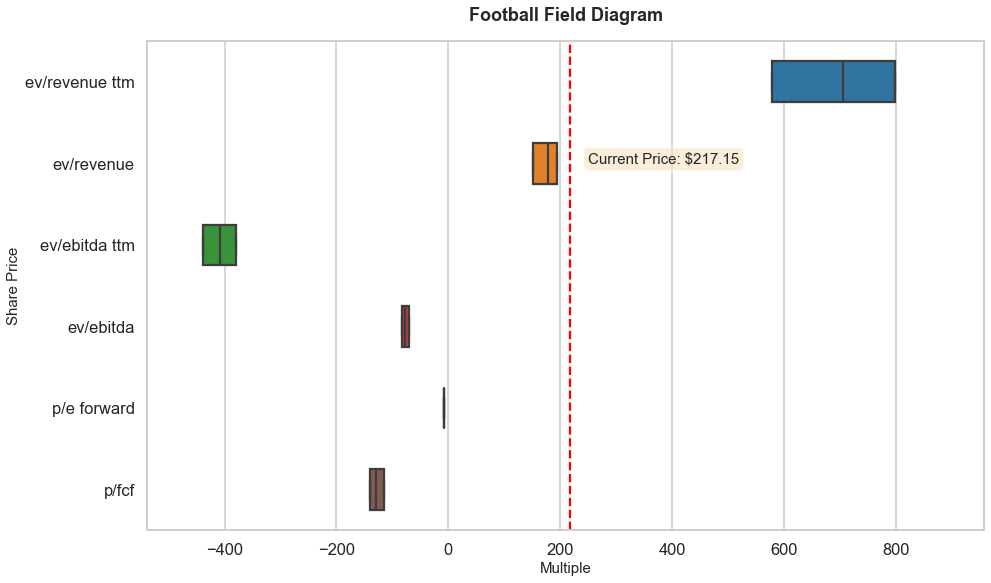

In [24]:
footballfield(iqr,"BA")

* Well, unfortunately, due to negative denominators the IQRs are all over the place. We'd drop all the negative values, leaving us with `ev/revenue` & `ev/revenue ttm`. The trailing 12 months implies a higher valuation range, because Covid was not as bad back then. I would have used forecasts for multiples, but unfortunately, accessing them is alot of hassle, it would require quite abit more code.

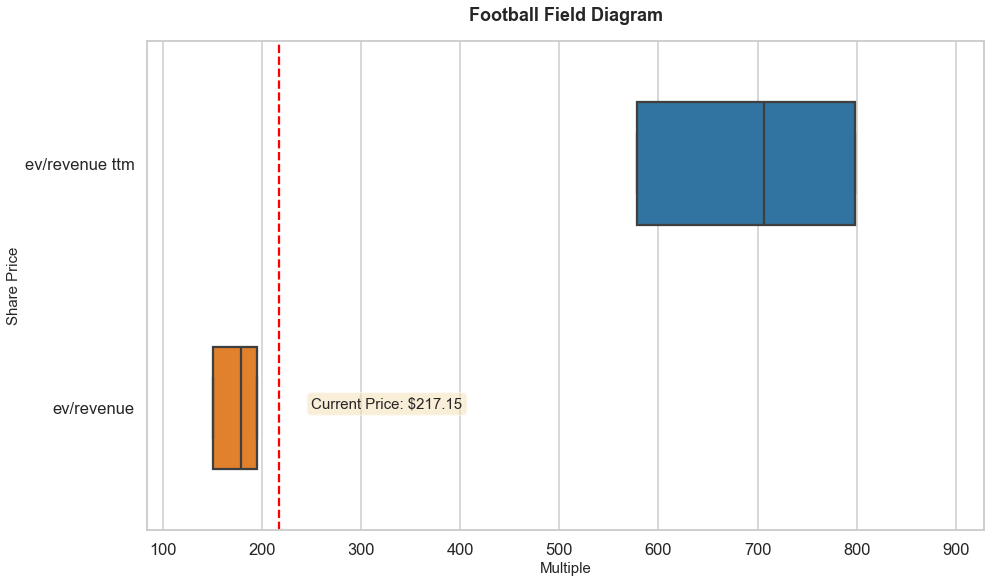

In [22]:
footballfield(iqr.iloc[:,[0,1]],"BA")

* Based on the only reasonble metric, `ev/revenue` with a median of 178.5, the target is overvalued by 21.65%. 

## Conclusion

* And that concludes the notebook! Obviously, this isn't a practical way of doing comparables, because Bloomberg Terminals and other Terminals have a built in comps screener for you, but this was just some exploration. 


* <b>Functions</b>: Due to using an in-built example of a target rather than just building functions and a meta-function to call of the functions at the end, the script is not entirely one giant function (input your target, assumptions, ranges and output a football field graph in one function), but it can be adapted, in case anyone ever needs to build comps fast next time.


* <b>Technical valuation details</b>: I know there are technical details overlooked with regard to the valuation, like not including forward or projected multiples, not using diluted shares outstanding, not looking at calendarization to ensure the periods are standardized and nice, etc. I know there is also the issue of not using NTM or forward-looking multiples, because extracting them out of the API/data was too troublesome.


* <b>Data</b>: There are several ways of accessing financial data with Python. One is to manually scrape it yourself going to places like `Finviz` or `Yahoo Finance` or any other database. Another is to make requests to APIs like `financialmodellingprep API` or similar stock market APIs. And another is to use packages like `yahoo_fin`, `yfinance`, etc that already do their own scraping from a database. But these all have limited data. For example, `finviz` only covers stocks listed in US exchanges. 


* <b>Valuation</b>: The problem with valuation is that it really is impossible to prove a link between any valuation method and the "true" stock price, because the price is fundamentally based on supply and demand, which is determined by people's perception of the stock and the market, and different entities will always have different perspectives. 